# UNET model

### Segmentation Method

## Get packages

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow import keras

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from keras.models import *
from keras.layers import *
import tensorflow as tf
import tensorflow as tf

from tqdm import tqdm
import cv2

from skimage.io import imread
from skimage.io import imshow
from skimage.util import crop
from skimage.transform import resize
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback

## Paths and size

In [2]:
# s-a ales din setul de date de 468 img 75% pt antrenare si 25% pentru testare si validare

TRAIN_PATH = 'archive/segmentation/no_only_train/neaug/train/'
# VALID_PATH = 'archive/segmentation/no_only_train/aug/validation/'
TEST_PATH = 'archive/segmentation/no_only_train/neaug/test/'

seed = 42
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
valid_ids = next(os.walk(VALID_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
IMG_WIDTH = 352
IMG_HEIGHT = 352
IMG_CHANNELS = 3

## Load and Prepare Images

In [4]:
# print('Resizing training images and masks')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent = {}
# print('Resizing training images and masks')

correspondent = {}

#train images
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  # Fill empty X_train with values from img
    correspondent[n] = str(id_)

# #train masks
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask_

    
# #validation images    
# X_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
# Y_valid = np.zeros((len(valid_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

# for n, id_ in tqdm(enumerate(valid_ids), total=len(valid_ids)):
#     path = VALID_PATH + id_
#     img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
#     img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     X_valid[n] = img  # Fill empty X_valid with values from img
#     correspondent[n] = str(id_)

# # validation masks
#     mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
#     mask_ = imread(path + '/masks/' + id_ + '.png')
#     mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
#     mask = np.maximum(mask, mask_)
    
#     Y_valid[n] = mask_

100%|█████████████████████████████████████████| 747/747 [00:26<00:00, 28.68it/s]


In [15]:
## # test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
correspondent_test = {}
size_test = []
print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    size_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
    mask_ = imread(path + '/masks/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True),-1)
    mask = np.maximum(mask, mask_)
    
    Y_test[n] = mask_
print('Done!')

Resizing test images


100%|███████████████████████████████████████████| 94/94 [00:03<00:00, 27.31it/s]

Done!


## Visualize the images

410


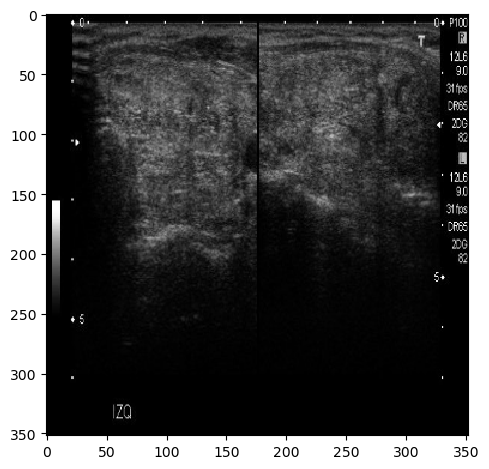

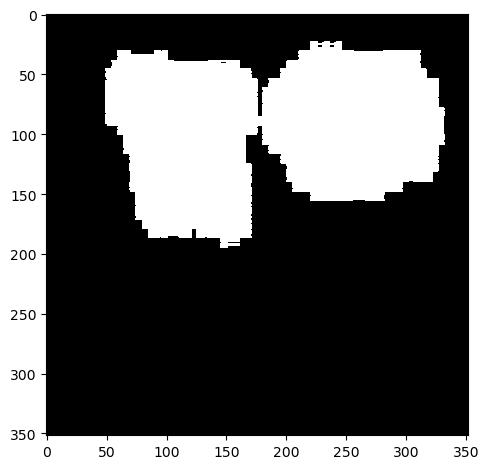

In [6]:
 image_x = random.randint(0, len(train_ids)-1)
#image_x = 240
print(image_x)
# print(correspondent[image_x])
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

## Make the model

In [7]:
#build the U-Net model.
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

# the input has to be changed from 8-bit to a floating point.
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Contraction path

# kernel_initializor defines the initial values, he_normal is a truncated normal
# distribution, other exemple Orthogonal, identity normal (gaussian distribution).

c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# dropout 10% form c1.
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D(2,2)(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 352, 352, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 352, 352, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 352, 352, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 352, 352, 16)         0         ['conv2d[0][0]']              
                                                                                              

 conv2d_15 (Conv2D)          (None, 176, 176, 32)         9248      ['dropout_7[0][0]']           
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 352, 352, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 352, 352, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 352, 352, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8

In [8]:
# compile the model
model.compile(
              optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
             )

## Train the model

In [9]:
# Se antreneaza modelul
checkpoiter = tf.keras.callbacks.ModelCheckpoint('model_unet_no_aug.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpoiter

]
results = model.fit(X_train, Y_train, 
                    validation_split=0.2, 
                    batch_size=8, 
                    epochs=25, 
                    callbacks=callbacks)

Epoch 1/25
75/75 [==============================] - ETA: 0s - loss: 0.3481 - accuracy: 0.8807
Epoch 1: val_loss improved from inf to 0.23832, saving model to model_unet_no_aug.h5
75/75 [==============================] - 153s 2s/step - loss: 0.3481 - accuracy: 0.8807 - val_loss: 0.2383 - val_accuracy: 0.8986
Epoch 2/25


/Users/taras_lara/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8940
Epoch 2: val_loss improved from 0.23832 to 0.23446, saving model to model_unet_no_aug.h5
75/75 [==============================] - 216s 3s/step - loss: 0.2609 - accuracy: 0.8940 - val_loss: 0.2345 - val_accuracy: 0.8986
Epoch 3/25
75/75 [==============================] - ETA: 0s - loss: 0.2421 - accuracy: 0.8940
Epoch 3: val_loss improved from 0.23446 to 0.22244, saving model to model_unet_no_aug.h5
75/75 [==============================] - 279s 4s/step - loss: 0.2421 - accuracy: 0.8940 - val_loss: 0.2224 - val_accuracy: 0.8986
Epoch 4/25
75/75 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.8940
Epoch 4: val_loss improved from 0.22244 to 0.20181, saving model to model_unet_no_aug.h5
75/75 [==============================] - 341s 5s/step - loss: 0.2183 - accuracy: 0.8940 - val_loss: 0.2018 - val_accuracy: 0.8986
Epoch 5/25
75/75 [==============================] - ETA: 0s - loss: 0.22

## Load the model

In [82]:
# Se incarca modelul antrenat anterior
# model = tf.keras.models.load_model('model_augmented12_for_nuclei.h5')

## Get prediction

In [21]:
idx = random.randint(0, len(X_test))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


3/3 [==============================] - 8s 3s/step


## Results

In [17]:
print('Accuracy Score = ',np.max(results.history['val_accuracy']))
print('Loss Score = ',np.min(results.history['val_loss']))

Accuracy Score =  0.8986203670501709
Loss Score =  0.20181185007095337


### During training

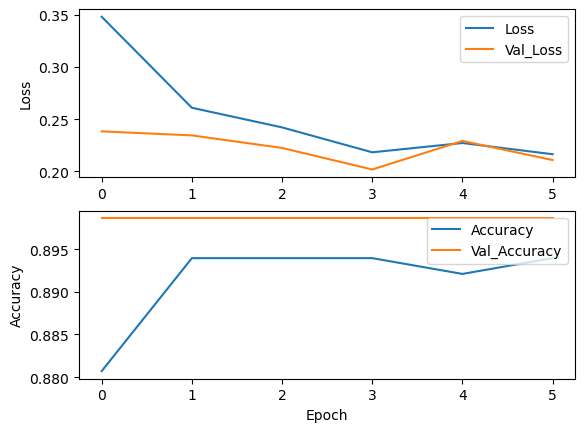

In [18]:
plt.figure()
plt.subplot(211)
loss_train_curve = results.history["loss"]
loss_val_curve = results.history["val_loss"]
plt.plot(loss_train_curve, label = "Loss")
plt.plot(loss_val_curve, label = "Val_Loss")
plt.legend(loc = 'upper right')
plt.ylabel("Loss")


plt.subplot(212)
acc_train_curve = results.history["accuracy"]
acc_val_curve = results.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Accuracy")
plt.plot(acc_val_curve, label = "Val_Accuracy")
plt.legend(loc = 'upper right')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

### Visualize the images

Image number:  73


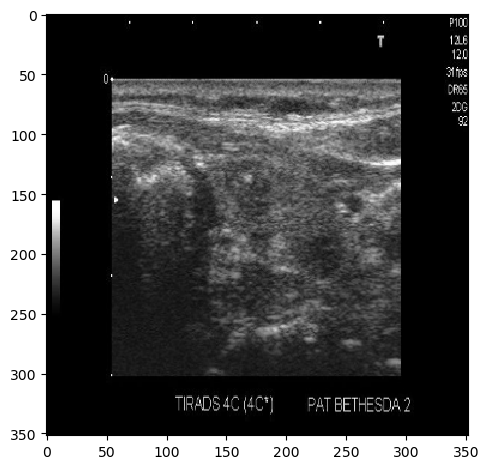

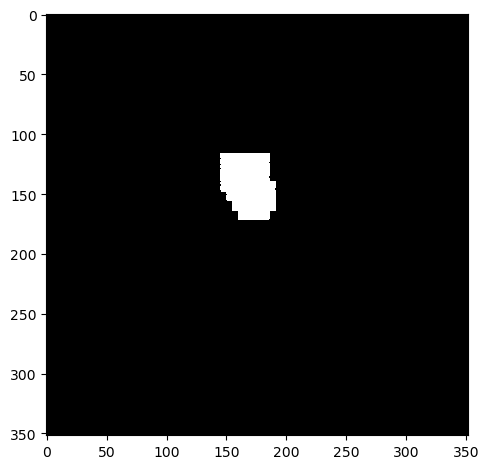

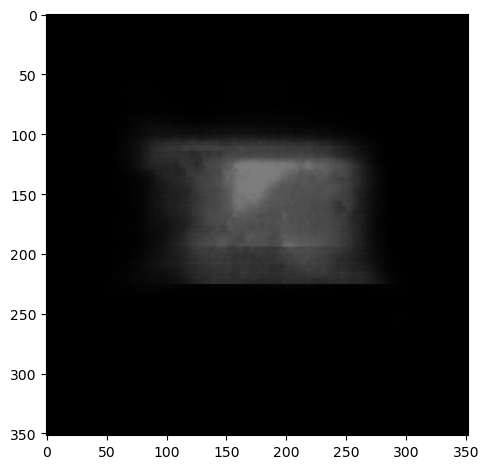

In [20]:
x = random.randint(0, len(preds_test_t))

print("Image number: ",x)
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test[x]))
plt.show()

### Test the model

In [14]:
# Pentru a vedea media performantelor metricilor pe care le-a obținut
iou = 0
iou2 = 0
accuracy = 0
accuracy2 = 0
f1_score2 = 0
f1_score = 0
mcc2 = 0
mcc = 0

for x in range(len(correspondent_test)):
# Se afiseaza imaginea impreuna cu masca si predictia
    imshow(X_test[x])
    plt.show()
    imshow(np.squeeze(Y_test[x]))
    plt.show()
    imshow(np.squeeze(preds_test_t[x]))
    plt.show()

    print("Image number: ", correspondent_test[x])

    gtMask = Y_test[x]
    predMask = preds_test_t[x]   

    # Get the parameters value 
    tp = 0
    fp = 0
    fn = 0
    tn = 0

#     def calculate_confusion_matrix(pred_mask, gtMask):
#     tp = np.sum((pred_mask == 1) & (true_mask == 1))
#     fp = np.sum((pred_mask == 1) & (true_mask == 0))
#     fn = np.sum((pred_mask == 0) & (true_mask == 1))
#     tn = np.sum((pred_mask == 0) & (true_mask == 0))

#     return tp, fp, fn, tn


    for i in range(len(gtMask)):
        for j in range(len(gtMask[i])):
            if gtMask[i][j] == True and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == False and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == True and predMask[i][j] == 0:
                fn += 1
            elif gtMask[i][j] == False and predMask[i][j] == 0:
                tn += 1

    # Show the Confusion Matrix          
    cmat = [[tp, fn], [fp, tn]]
    plt.figure(figsize = (6,6))
    sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


    # Print parameters
    print(f"TP: {tp}, FP: {fp}, FN: {fn}, TN: {tn}")

    # Calculate the evaluation metrics
    iou2 = tp / (tp + fp + fn)
    total2 = tp + fp + fn + tn
    accuracy2 = (tp + tn) / total2
    f1_score2 = (2 * tp) / ((2 * tp) + fp + fn)
    mcc2 = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
    
    if np.isnan(mcc2):
        mcc2 = 0
    if np.isnan(accuracy2):
        accuracy2 = 0
    if np.isnan(f1_score2):
        f1_score2 = 0
    if np.isnan(iou2):
        iou2 = 0
    
    iou2 = round(iou2*100, 3)
    accuracy2 = round(accuracy2*100, 3)
    f1_score2 = round(f1_score2*100, 3)
    mcc2 = round(mcc2*100, 3)
    
    iou = iou + iou2
    accuracy = accuracy + accuracy2
    f1_score = f1_score + f1_score2
    mcc = mcc + mcc2
    
    # Print the evaluation metrics
print("MCC: ", mcc)
print("MCC: ", mcc/len(correspondent_test), "%")
print("F1: ", f1_score/len(correspondent_test), "%")
print("Acc: ", accuracy/len(correspondent_test), "%")    
print("IoU: ", iou/len(correspondent_test), "%")

NameError: name 'correspondent_test' is not defined

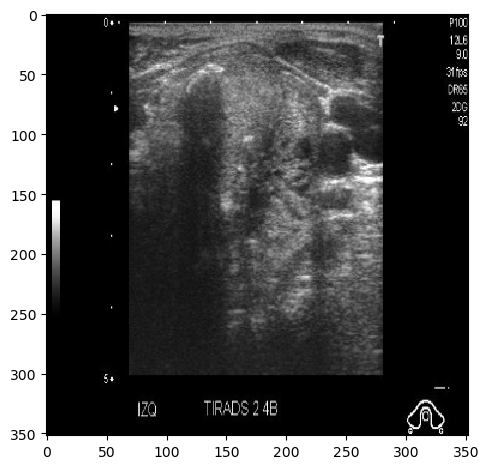

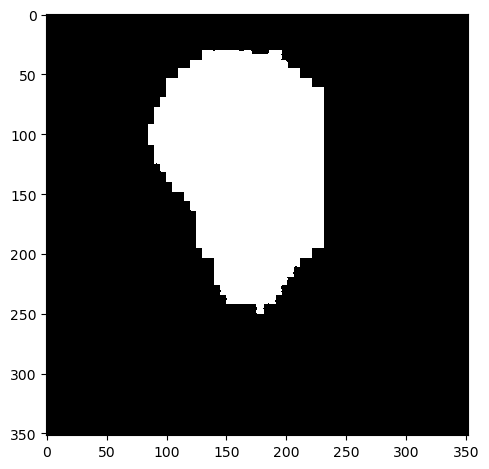

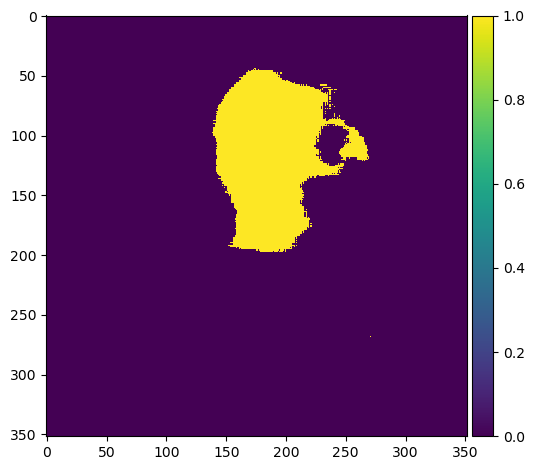

Image number:  156


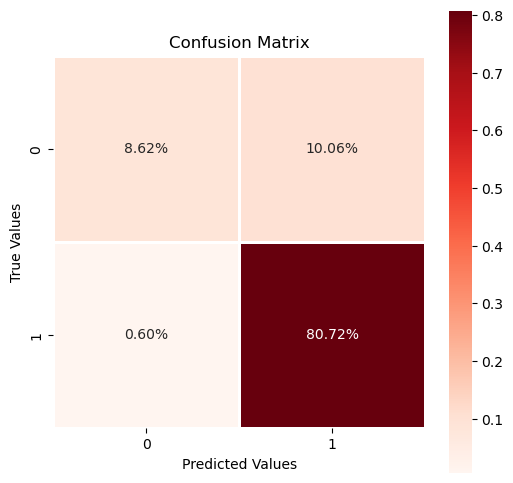

True positive:  10679
False positive:  738
False negative:  12468
True negative:  100019
Dice:  61.793 %
Acc:  89.342 %
IoU:  44.71 %
F1:  61.793 %


In [98]:
# Pentru a vedea valorile metricilor ale unei singure imagini
# Se alege un numar aleator    
x = random.randint(0, len(preds_test_t))

# Se afiseaza imaginea impreuna cu masca si predictia
imshow(X_test[x])
plt.show()
imshow(np.squeeze(Y_test[x]))
plt.show()
imshow(np.squeeze(preds_test_t[x]))
plt.show()
print("Image number: ",x)

gtMask = Y_test[x]
predMask = preds_test_t[x]   

# Get the parameters value 
tp = 0
fp = 0
fn = 0
tn = 0

for i in range(len(gtMask)):
    for j in range(len(gtMask[i])):
        if gtMask[i][j] == True and predMask[i][j] == 1:
            tp += 1
        elif gtMask[i][j] == False and predMask[i][j] == 1:
            fp += 1
        elif gtMask[i][j] == True and predMask[i][j] == 0:
            fn += 1
        elif gtMask[i][j] == False and predMask[i][j] == 0:
            tn += 1

# Show the Confusion Matrix          
cmat = [[tp, fn], [fp, tn]]
plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1,   linewidth=2.)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.title("Confusion Matrix")
plt.show()

# Print parameters
print("True positive: ",tp)
print("False positive: ",fp)
print("False negative: ",fn)
print("True negative: ",tn)


# Calculate the evaluation metrics
iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
accuracy = (tp + tn) / (tp + fp + fn + tn)
dice = (2 * tp) / ((2 * tp) + fp + fn) if ((2 * tp) + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = (2 * precision * recall)/(precision + recall) if (precision + recall) > 0 else 0

# Print the evaluation metrics
print("Dice: ", round(dice*100, 3), "%")
print("Acc: ", round(accuracy*100, 3), "%")    
print("IoU: ", round(iou*100, 3), "%")
print("F1: ", round(f1_score*100, 3), "%")